# Classify whether a payment was done in a research context or not

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Identify Features

### We assemble a dataset consisting of features and target. Questions we ask ourselves at this point are: what features are relevant for the prediction task? What features should be excluded because they leak the target information?

Let us load the two data files (each contain records of one class):

In [3]:
df_gen = pd.read_csv("data/OP_DTL_GNRL_PGYR2017_P01182019.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_rch = pd.read_csv("data/OP_DTL_RSRCH_PGYR2017_P01182019.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,5,7,8,9,10,12,15,17,18,19,20,21,22,23,24,25,30,32,35,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,129,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,163,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let us see how balanced the data is:

In [5]:
n_gen = df_gen.shape[0]
n_rch = df_rch.shape[0]
print(n_rch/n_gen)

0.05650219766194763


The data is **very imbalanced**! To deal with this imbalance upstream we will sample more of the minority class when making our dataset (we will aim at a 20/80 ratio to still keep some imbalance and be closer to the real-world context than a 50/50 split - albeit we are still very far from the actual 5/100 ratio)

We create the target variable:

In [6]:
df_gen['is_rch'] = 0

In [7]:
df_rch['is_rch'] = 1

**One way to start figuring one which variables leak information on the target is to see which variables appear in only one of the files - they are part of the leaking variables**. Such variables are:

In [8]:
in_gen_not_rch = set(df_gen.columns)-set(df_rch.columns)
in_rch_not_gen = set(df_rch.columns)-set(df_gen.columns)
in_both = set(df_gen.columns).intersection(set(df_rch.columns))

We sample from both datasets (10,000 records total), keeping only the columns they have in common:

In [9]:
df_gen = df_gen[list(in_both)]
df_rch = df_rch[list(in_both)]

In [10]:
df_gen = df_gen.sample(n=8000, random_state=0)
df_rch = df_rch.sample(n=2000, random_state=0)

In [11]:
df = pd.concat([df_gen, df_rch])

To (try to) free some memory:

In [12]:
del df_gen
del df_rch

In [13]:
#df.to_csv("data/concatenated.csv", index=False)

In [14]:
#df = pd.read_csv("data/concatenated.csv")

We shuffle records so that we don't have to worry about the ordering of the target variable later:

In [15]:
df = df.sample(frac=1, random_state=0)

We create a copy of the dataset so that we work on a separate dataset while still having the opportunity to fetch back some columns from the original dataset.

In [16]:
working_df = df.copy()

In [17]:
working_df.shape

(10000, 65)

We now see how many missing values there are in the columns to discard those that might have too many missing values.

In [18]:
working_df.isnull().sum()

Covered_Recipient_Type                                                 0
Recipient_Country                                                      1
Associated_Drug_or_Biological_NDC_5                                 9983
Physician_License_State_code2                                       9824
Recipient_Primary_Business_Street_Address_Line2                     6598
Form_of_Payment_or_Transfer_of_Value                                   0
Associated_Drug_or_Biological_NDC_2                                 8518
Program_Year                                                           0
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID            0
Physician_Last_Name                                                 1951
Teaching_Hospital_Name                                              9667
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2           8267
Dispute_Status_for_Publication                                         0
Recipient_State                                    

To reduce the set of predictors to choose from: we remove predictors that have more than 9,000 missing values (out of a little over 10,000 rows) - we might go back and fetch some of these later as `NA` values for categorical variable can carry a lot of information.

In [19]:
working_df = working_df.iloc[:,list(df.isna().sum() < 9*1e3)]

Furthermore, some features might have no missing values, but they might not carry any information:

In [20]:
working_df['Payment_Publication_Date'].unique()

array(['01/18/2019'], dtype=object)

In [21]:
working_df['Program_Year'].unique()

array([2017])

In [22]:
working_df['Delay_in_Publication_Indicator'].unique()

array(['No'], dtype=object)

Columns `Payment_Publication_Date`, `Program_Year`, `Delay_in_Publication_Indicator` have only one value and so are completely uninformative for classification purposes.

Column `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name` (categorical) has 533 distinct value as well as formatting issues (same company can have different strings representing it). While we could use Bayesian target encoding to incorporate it in the model this would probably do more harm than good with information leakage. **With respect to our data size (10,000 rows for train+test) we probably can't afford to keep such variables that would make our data too high-dimensional with not enough data to capture the intricacies of the dimensions)**.

For similar reasons we will also remove `Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name`, `Recipient_Primary_Business_Street_Address_Line1`, `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID`, `Physician_Middle_Name`, `Physician_First_Name`, `Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2`, `Record_ID`, `Recipient_City`, `Recipient_Zip_Code`, `Physician_Last_Name`, `Physician_Profile_ID`, `Associated_Drug_or_Biological_NDC_2`, `Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1`, `Recipient_Primary_Business_Street_Address_Line2`, `Associated_Drug_or_Biological_NDC_1`, `Product_Category_or_Therapeutic_Area_1`, `Product_Category_or_Therapeutic_Area_2`

In [23]:
to_keep = ['Physician_License_State_code1',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
           'Related_Product_Indicator',
           'Physician_Primary_Type',
           'Form_of_Payment_or_Transfer_of_Value',
           'Change_Type',
           'Covered_or_Noncovered_Indicator_2',
           'Total_Amount_of_Payment_USDollars',
           'Recipient_State',
           'Date_of_Payment',
           'Physician_Specialty',
           'Covered_Recipient_Type',
           'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
           'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
           'Covered_or_Noncovered_Indicator_1',
           'Recipient_Country',
           'Dispute_Status_for_Publication',
           'is_rch']

In [24]:
working_df = working_df[to_keep]

In [25]:
n_rows = working_df.shape[0]

We still have two variables that could be too obviously correlated: `Recipient_State` and `Physician_License_State_code1`. Indeed there are equal for the following proportion of rows:

In [26]:
(working_df['Recipient_State'] == 
 working_df['Physician_License_State_code1']).sum() / n_rows

0.7109

This ratio is very high considering that there are 50 different possible values for each.

We will keep only `Recipient_State` (somewhat arbitrarily) for now and might go back an replace it with `Physician_License_State_code1` to see if the model performs better.

In [27]:
to_remove = ['Physician_License_State_code1']

We also need to extract information from `Physician_Specialty` in which specialties are separated by `|`. We extract the values in three new columns.

In [28]:
working_df[['Physician_Specialty_1', 
    'Physician_Specialty_2', 
    'Physician_Specialty_3']] = working_df['Physician_Specialty'].str.split('|', expand=True)

It seems like specialties are getting more specific from `Physician_Specialty_1` to `Physician_Specialty_3`:

In [29]:
len(working_df['Physician_Specialty_1'].unique())

11

In [30]:
len(working_df['Physician_Specialty_2'].unique())

44

In [31]:
len(working_df['Physician_Specialty_3'].unique())

118

Only `Physician_Specialty_1` and maybe `Physician_Specialty_2` seem like manageable-sized categorical variable so we will keep only these (and might have to drop `Physician_Specialty_2` later):

In [32]:
to_remove.append('Physician_Specialty_3')
to_remove.append('Physician_Specialty')

We also have two variables that may deliver redundant information: `Covered_Recipient_Type`, `Covered_or_Noncovered_Indicator_1`

In [33]:
((working_df['Covered_Recipient_Type'] == 'Non-covered Recipient Entity') 
 == (working_df['Covered_or_Noncovered_Indicator_1'] == 'Non-covered')).sum() / n_rows

0.8383

The category 'Non-covered Recipient Entity' is strongly correlated with 'Non-covered' as expected and they represent the majority of records. We will keep only `Covered_Recipient_Type` that is more fine-grained and might deliver more valuable (we hope) information.

In [34]:
to_remove.append('Covered_or_Noncovered_Indicator_1')

We remove those few variables we decided to take out and look at the shape of our data now:

In [35]:
working_df = working_df.drop(columns=to_remove)
print(working_df.shape)

(10000, 18)


Our data is pretty tall as of now but we expect to grow much wider after one-hot-encoding of some categorical variables.

**Now that we have some promising candidates for our features, let us now observe how some variables are related to the target to justify keeping or dropping them**:

In [36]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Physician_Primary_Type',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Date_of_Payment', 'Covered_Recipient_Type',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Recipient_Country', 'Dispute_Status_for_Publication', 'is_rch',
       'Physician_Specialty_1', 'Physician_Specialty_2'],
      dtype='object')

In [37]:
to_remove = []

*Let us now look at the distribution of the predictors and how it varies with values of the target variable:*

- `Physician_Specialty` 

Physician_Specialty seems to have a problematic pattern

In [38]:
num_na = working_df.loc[df['is_rch']==1]['Physician_Specialty_1'].isna().sum()
num_row = working_df.loc[df['is_rch']==1].shape[0]
num_na/num_row

0.9605

In [39]:
num_na = working_df.loc[df['is_rch']==0]['Physician_Specialty_1'].isna().sum()
num_row = working_df.loc[df['is_rch']==0].shape[0]
num_na/num_row

0.005

0.5% of the values are NaN for the non-research payments whereas research payments have more than 96% missing values. Therefore, the feature 'Physician_Specialty_1' is leaking the target. Therefore, we will remove it from the data.

In [40]:
to_remove.append('Physician_Specialty_1')

In [41]:
num_na = working_df.loc[df['is_rch']==1]['Physician_Specialty_2'].isna().sum()
num_row = working_df.loc[df['is_rch']==1].shape[0]
num_na/num_row

0.9605

In [42]:
num_na = working_df.loc[df['is_rch']==0]['Physician_Specialty_2'].isna().sum()
num_row = working_df.loc[df['is_rch']==0].shape[0]
num_na/num_row

0.005

0.5% of the values are NaN for the non-research payments whereas research payments have more than 96% missing values. Therefore, the feature 'Physician_Specialty_2' is also leaking the target, and will also be removed from the dataset.

In [43]:
to_remove.append('Physician_Specialty_2')

- `Physician_Primary_Type`

This feature has the same issue as the Physician_specialty: its missing value pattern leaks data

In [44]:
num_na = working_df.loc[df['is_rch']==1]['Physician_Primary_Type'].isna().sum()
num_row = working_df.loc[df['is_rch']==1].shape[0]
num_na/num_row

0.9605

In [45]:
num_na = working_df.loc[df['is_rch']==0]['Physician_Primary_Type'].isna().sum()
num_row = working_df.loc[df['is_rch']==0].shape[0]
num_na/num_row

0.00375

Because one class has almost only missing values, and the other has almost no missing value, this feature is leaking information on the target, and we will remove it from the dataset.

In [46]:
to_remove.append('Physician_Primary_Type')

- `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country` 

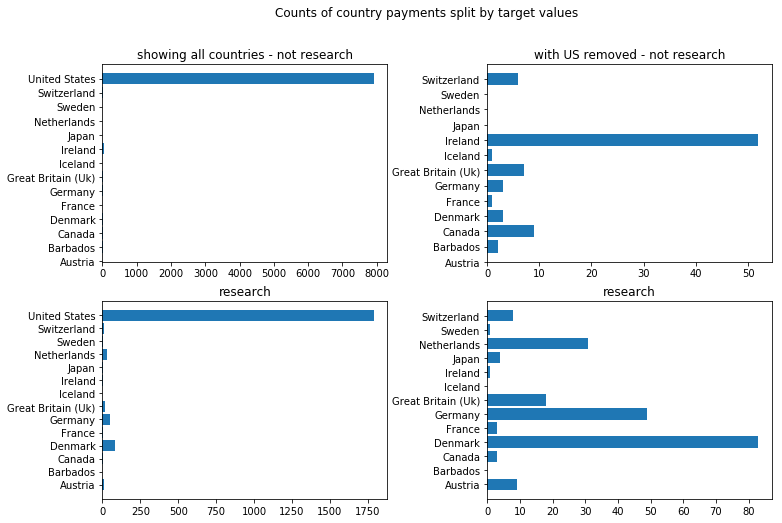

In [47]:
temp = working_df.groupby(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 
                   'is_rch'])['is_rch'].count()
temp = temp.unstack(1)
temp.index.name = "countries"

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Counts of country payments split by target values")

ax[0, 0].barh(y=temp.index, width=temp[0])
ax[0, 0].set_title("showing all countries - not research")

ax[1, 0].barh(y=temp.index, width=temp[1])
ax[1, 0].set_title("research")

temp = temp.drop('United States', axis=0)

ax[0, 1].barh(y=temp.index, width=temp[0])
ax[0, 1].set_title("with US removed - not research")

ax[1, 1].barh(y=temp.index, width=temp[1])
ax[1, 1].set_title("research")

fig.subplots_adjust(wspace=.35)

Above are bar charts of counts of each payment split across values of the target (research/not research) horizontally, and with and without the US included to gain more insight on the full distribution. **Looking at these plots we see that the distribution across countries outside of the US is very different between research and non-research payments. This suggests that the predictor might be helpful to predict the target but only rather for the payments outside of the US - a minority of payments. Since a large majority of payments are made from the US, this predictor is certainly not sufficient to explain the target on its own.**

- `Form_of_Payment_or_Transfer_of_Value`

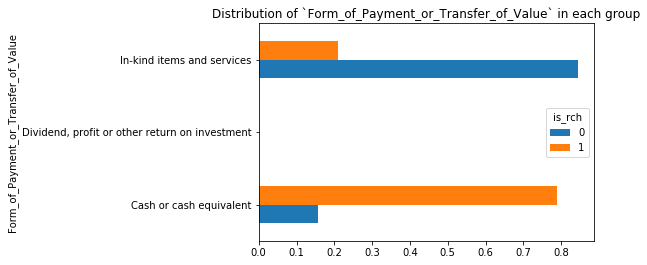

In [48]:
temp = working_df.groupby(['Form_of_Payment_or_Transfer_of_Value', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='barh', title="Distribution of `Form_of_Payment_or_Transfer_of_Value` in each group")

**This feature seems particularly valuable in predicting if a payment is a research one or not!**

- `Total_Amount_of_Payment_USDollars`

In [49]:
working_df1 = working_df[working_df['is_rch'] == 0]
working_df2 = working_df[working_df['is_rch'] == 1]

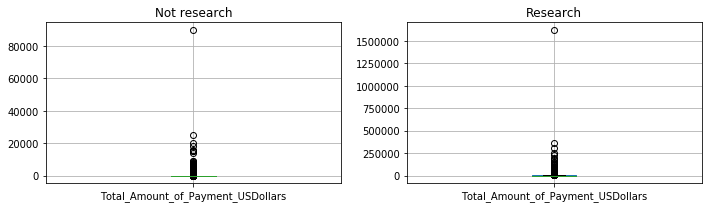

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Not research')
ax[1].set_title('Research')
working_df1.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[0])
working_df2.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[1])
fig.tight_layout()

These boxplots show two very strong outliers, one for each target value. **Should we decide to keep this variable as a feature, we will need to remove those observations altogether as they risk distorting our predictions significantly**. Let us filter the bulk of outliers out and look at the distribution again:

In [51]:
working_df1 = working_df1[working_df1['Total_Amount_of_Payment_USDollars'] < 40000]
working_df2 = working_df2[working_df2['Total_Amount_of_Payment_USDollars'] < 40000]

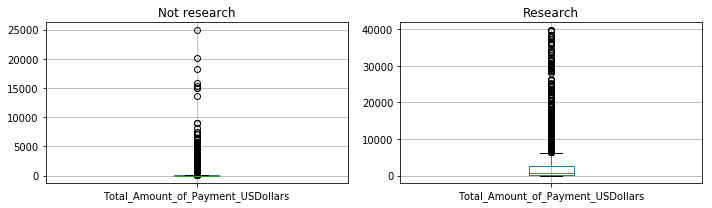

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Not research')
ax[1].set_title('Research')
working_df1.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[0])
working_df2.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[1])
fig.tight_layout()

Both distributions are concentrated around low values of the payments (low compared to the possible range of payments found in the data) but seem significantly different, with research grants densely populated with outliers. **This variable seems like a potentially useful predictor**.

As previously mentioned, we need to get rid of the two extreme outliers:

In [53]:
working_df = working_df[working_df['Total_Amount_of_Payment_USDollars'] < 80000]

- `Related_Product_Indicator`

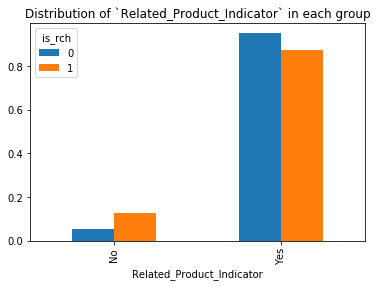

In [54]:
temp = working_df.groupby(['Related_Product_Indicator', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='bar', title="Distribution of `Related_Product_Indicator` in each group")

This plot shows that the distribution of `Related_Product_Indicator` is a little different conditional on the values of `is_rch`. There are more than 10 times more `Yes` than `No` conditional on `is_rch = 0` and about only 6 times more `Yes` than `No` conditional on `is_rch = 1`. This feature might be useful to predict `is_rch` but perhaps not very significantly so we'll drop it for now.

In [55]:
to_remove.append('Related_Product_Indicator')

Variable `Covered_Recipient_Type` **leaks too much information on the target** (see below) so we will also remove it:

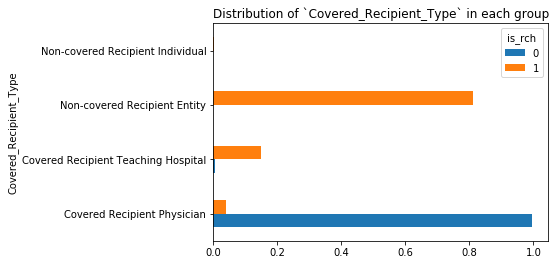

In [56]:
temp = working_df.groupby(['Covered_Recipient_Type', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='barh', title="Distribution of `Covered_Recipient_Type` in each group")

In [57]:
to_remove.append('Covered_Recipient_Type')

The two following variables have only one value across the dataset so we discard them as well:

In [58]:
to_remove.append('Recipient_Country')
to_remove.append('Dispute_Status_for_Publication')

We keep the other variables that are potentially informative. The final features are as follows:

In [59]:
working_df = working_df.drop(columns=to_remove)

In [60]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Date_of_Payment',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'is_rch'],
      dtype='object')

## Preprocessing and Baseline Model

### We create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model.

We are going to create an initial model with the features that we selected previously.

The only continuous feature we have is `Total_Amount_of_Payment_USDollars`.

In [61]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Date_of_Payment',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'is_rch'],
      dtype='object')

In [62]:
cont = ['Total_Amount_of_Payment_USDollars']
cat = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1']

We check if we have missing values:

In [63]:
working_df.isna().any()

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    False
Form_of_Payment_or_Transfer_of_Value                                False
Change_Type                                                         False
Covered_or_Noncovered_Indicator_2                                    True
Total_Amount_of_Payment_USDollars                                   False
Recipient_State                                                      True
Date_of_Payment                                                     False
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2            True
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State       True
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1            True
is_rch                                                              False
dtype: bool

Missing values appear only in categorical variables. We will create a category for them for the 4 variables that have them (for both train and test data):

In [64]:
working_df = working_df.replace(to_replace={var:np.NaN for var in cat}, 
                                value="N/A")

**We can now split the data into training and test and only work with the training data, using the test data for performance measurement only**

In [65]:
y = working_df['is_rch']
working_df = working_df.drop(columns=['is_rch'])

In [66]:
from sklearn.model_selection import train_test_split

train, test, y_train, y_test = train_test_split(working_df, 
                                                y, test_size=.2, 
                                                random_state=0, 
                                                stratify=y)

We remove the date column from the train and test set since we will process it in the later part of the homework

In [67]:
train = train.drop(['Date_of_Payment'],axis=1)
test = test.drop(['Date_of_Payment'],axis=1)

We will now **randomly select 3 out of the 11 categorical features** and add the continuous feature to build our baseline model on:

In [68]:
np.random.seed(20190304)

In [69]:
working_df.shape

(9977, 10)

In [70]:
rand = np.random.choice(range(9), size=6, replace=False)
train_col_sample = train.drop(columns=train.columns[rand], axis=1)
train_col_sample['Total_Amount_of_Payment_USDollars'] = train['Total_Amount_of_Payment_USDollars']

In [71]:
train_col_sample.columns

Index(['Change_Type',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Total_Amount_of_Payment_USDollars'],
      dtype='object')

In [72]:
cat_col_sample = ['Change_Type',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1']

As we observed many outliers in `Total_Amount_of_Payment_USDollars` we will use a **robust scaler** for preprocessing. We will **one-hot encode** all other variables. Finally we will fit a **logistic regression** with default parameters and evaluate it with a **10 fold cross-validation** - looking at **average precision and ROC-AUC** (particularly adapted to imbalanced data such as here).

In [73]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate

In [74]:
encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat_col_sample])
preprocess = make_column_transformer((RobustScaler(), cont), 
                                     (encoder, cat_col_sample))
baseline = make_pipeline(preprocess, LogisticRegression(solver='saga', penalty='l1',
                                                        max_iter=1e4))

In [75]:
scores = cross_validate(baseline, train_col_sample, y_train, cv=5,
                        scoring=("roc_auc", "average_precision"))

The **test scores** are:

In [76]:
baseline = baseline.fit(train_col_sample, y_train)

In [77]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [78]:
baseline_ap = average_precision_score(y_test, baseline.predict_proba(test)[:, 1])
baseline_ra = roc_auc_score(y_test, baseline.predict_proba(test)[:, 1])

In [79]:
baseline_ra, baseline_ap
print('The logistic regression BASELINE roc auc is {0:.3f}'.format(baseline_ra))
print('The logistic regression BASELINE average precision is {0:.3f}'.format(baseline_ap))

The logistic regression BASELINE roc auc is 0.890
The logistic regression BASELINE average precision is 0.728


We plot the **PR and ROC curves** on the **test set** to gain more insight on the model performance:

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [81]:
precision, recall, thresholds = precision_recall_curve(y_test, baseline.predict_proba(test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, baseline.predict_proba(test)[:, 1])

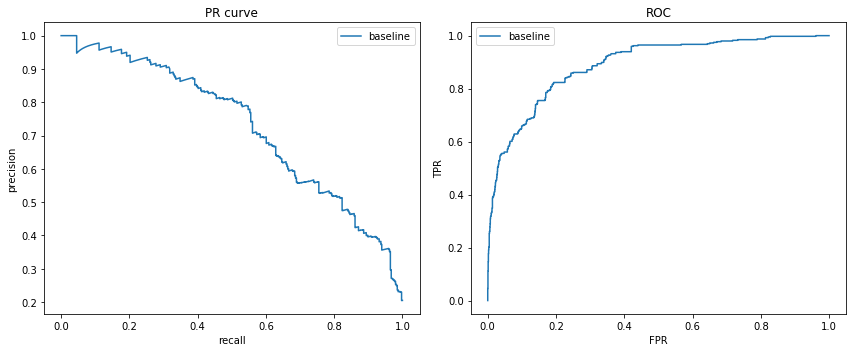

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

## More Feature Engineering

### We create derived features and perform more in-depth preprocessing and data cleaning. Does this improve the a new baseline model fit on these? 

Let us look at the features we have extracted so far:

In [83]:
train.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'],
      dtype='object')

And those among the above that were used in the baseline:

In [84]:
train_col_sample.columns

Index(['Change_Type',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Total_Amount_of_Payment_USDollars'],
      dtype='object')

**We will now extract several categorical features from the original `Date_of_Payment` feature:  `Day_of_month_of_Payment`, `Day_of_week_of_Payment`, `Month_of_Payment` and `Week_or_weekend_Payment`.**



To use `Date_of_Payment` we will extract information that can be useful for our models:

We create a feature: `Day_of_week_of_Payment`:

In [85]:
working_df['Date_of_Payment'] = pd.to_datetime(working_df['Date_of_Payment'])
working_df['Day_of_week_of_Payment'] = working_df['Date_of_Payment'].dt.day_name()

As well as an indicator variable `Week_or_weekend_Payment` (1 for a weekday and 0 for the weekend):

In [86]:
def weekend_map(row):
    if row['Day_of_week_of_Payment'] == 'Saturday':  
        return 1
    elif row['Day_of_week_of_Payment'] == 'Sunday':
        return 1
    else:
        return 0
    
working_df['Week_or_weekend_Payment'] = working_df.apply(weekend_map, axis=1).astype(object)

We also extract the day of the month (`Day_of_month_of_Payment`) as well as the month (`Month_of_Payment`):

In [87]:
working_df['Day_of_month_of_Payment'] = working_df['Date_of_Payment'].dt.day.astype(object)
working_df['Month_of_Payment'] = working_df['Date_of_Payment'].dt.month.astype(object)

And we get rid of the raw date.

In [88]:
working_df = working_df.drop('Date_of_Payment', axis=1)

Coming back on some features we have previously discarded: we can see that Teaching_Hospital_Name has slightly less chance to be missing for one class than for the other while it appears not to be causing any feature leak. Therefore, we can leverage that information for creating a new feature. 

In [89]:
num_na = df.loc[df['is_rch']==0]['Teaching_Hospital_Name'].isna().sum()
num_row = df.loc[df['is_rch']==0].shape[0]
num_na/num_row

0.99625

In [90]:
num_na = df.loc[df['is_rch']==1]['Teaching_Hospital_Name'].isna().sum()
num_row = df.loc[df['is_rch']==1].shape[0]
num_na/num_row

0.8485

In [91]:
working_df['Teaching_Hospital_Name'] = df['Teaching_Hospital_Name'].apply(lambda x: "N/A" 
                                                                          if x is None 
                                                                          else "Not_missing" )

Adding our own features and one more existing feature:

In [92]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Day_of_week_of_Payment', 'Week_or_weekend_Payment',
       'Day_of_month_of_Payment', 'Month_of_Payment',
       'Teaching_Hospital_Name'],
      dtype='object')

In [93]:
# we re-do the split, the random seed guarantees we will have the
# the same records in both train and test as before,
# with the added physician id
train, test, y_train, y_test = train_test_split(working_df, 
                                                y, test_size=.2, 
                                                random_state=0, 
                                                stratify=y)

In [94]:
cat = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Day_of_week_of_Payment', 'Week_or_weekend_Payment',
       'Day_of_month_of_Payment', 'Month_of_Payment','Teaching_Hospital_Name']

In [95]:
#To add all of the countries for the 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'

encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat])
preprocess = make_column_transformer((RobustScaler(), cont), 
                                     (encoder, cat))
baseline_improved = make_pipeline(preprocess, 
                                  LogisticRegression(solver='saga', 
                                                     penalty='l1',max_iter=1e4))

scores_2 = cross_validate(baseline_improved, train, y_train, cv=5,
                          scoring=("roc_auc", "average_precision"))

The **test scores** are:

In [96]:
baseline_improved = baseline_improved.fit(train, y_train)
baseline_imp_ap = average_precision_score(y_test, baseline_improved.predict_proba(test)[:, 1])
baseline_imp_ra = roc_auc_score(y_test, baseline_improved.predict_proba(test)[:, 1])

print('The logistic regression roc auc is {0:.3f}'.format(baseline_imp_ra))
print('The logistic regression average precision is {0:.3f}'.format(baseline_imp_ap))

The logistic regression roc auc is 0.942
The logistic regression average precision is 0.803


The baseline test scores were:

In [97]:
print('The logistic regression BASELINE roc auc is {0:.3f}'.format(baseline_ra))
print('The logistic regression BASELINE average precision is {0:.3f}'.format(baseline_ap))

The logistic regression BASELINE roc auc is 0.890
The logistic regression BASELINE average precision is 0.728


**We can see that those features give a better Roc Auc value and average precision**. Let us look at the PR and ROC curves:

In [98]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, 
                                                             baseline_improved.predict_proba(test)[:, 1])
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, 
                                       baseline_improved.predict_proba(test)[:, 1])

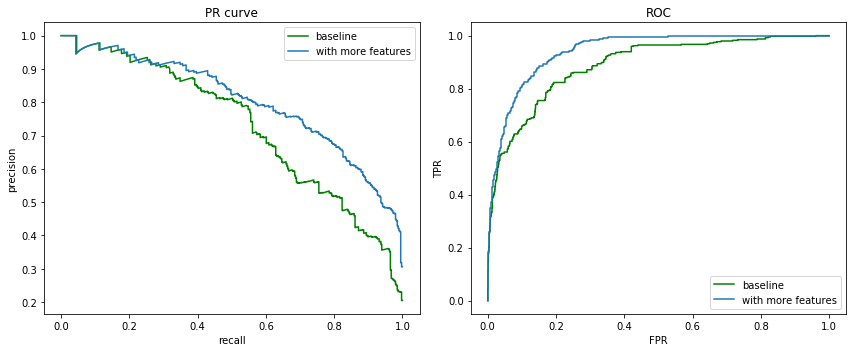

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, color ='g', label='baseline')
ax[0].plot(recall_2, precision_2, label='with more features')
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc='best')

ax[1].plot(fpr, tpr, color='g', label='baseline')
ax[1].plot(fpr_2, tpr_2, label='with more features')
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc='best')

fig.tight_layout()

From the curves, we can see that we get significantly better performance overall. The reason for it might be that the random sampling we did for the features is likely to have selected features that are less informative than others. Therefore, the new model gets way better results: the model with added features' curves are higher than the baseline's by quite a margin for any recall. It would seem that adding engineered features served our goal. However, for lower recall values, it is not obvious which set of features is actually better.

However, we can confidently say that our new model with added feature is a better model. If we want to push further the analysis, we can also talk about threshold selection.

Let us now give a context to our classification problem: this will enable us to choose a threshold with a goal in mind, rather than just broadly compare different metrics and pick the one that looks best on average.

Let us say that we want to classify payments so that we can more easily investigate research payments to see if they were fraudulous. With this goal in mind, we would prefer all research payments to be identified, with a small cost associated to a general payment identified as a research payment. On the other hand, identifying a research payment as a general one makes us unable to investigate it and a fraudulous payment might slip through: this has a higher cost.

**Therefore we would like our model's coverage (or recall) to be high.**

**To find the best threshold on the basis of this goal we need to look at high recall (TPR) areas on the curves.** We can see that, at a recall close to 0.8, we still get about 0.7 precision which can be still satisfying. However, for recalls higher than 0.8, we can see a pretty dramatic decrease in precision that could be a problem

## XGBoost

### We build another classification model and tune its parameters to improve our result.

The model that we have chosen is the xgBoost classifier: it generally has good performances and provides some useful insights thanks to its feature importance plot. For the categorical variables, we will still need to one hot encode them because xgBoost only supports float, int or bool type. However, for the continuous feature, we do not need to scale it anymore.

We are running a gridSearch over three different parameters: max_depth, colsample_bytree and learning_rate. We will set n_estimators at 500 since it is a satisfying number of estimators (since the default is 100), while the runtime for the gridSearch is still decent. We do not perform gridSearch over the number of estimators since we know that having more estimators can only increase the performance (or at least not have any effect) so the only constraint on this parameter is the training time.

In [100]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# TO avoid having crashing kernels with xgBoost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat])
preprocess = make_column_transformer(('passthrough', cont), 
                                     (encoder, cat))
#pipe = make_pipeline(preprocess,xgb.XGBClassifier())
pipe = Pipeline(steps=[('preprocessor', preprocess),
                ("classifier",xgb.XGBClassifier())])

params = {'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
          'classifier__n_estimators': [500],
          'classifier__max_depth' : [3,6,9],
          'classifier__colsample_bytree': [0.6, 0.8, 1.0]
    
}


grid = GridSearchCV(pipe, params, 
                    scoring=("roc_auc", "average_precision"),
                    refit="average_precision", n_jobs=-1, cv=5)
grid.fit(train, y_train)
print('The best parameters are:' + str(grid.best_params_))

tuned_pipe = grid.best_estimator_
#The estimator has been refitted to the entire dataset by the gridSearch based on the parameters for the
#best roc auc value
pipe_ap = average_precision_score(y_test, tuned_pipe.predict_proba(test)[:, 1])
pipe_ra = roc_auc_score(y_test, tuned_pipe.predict_proba(test)[:, 1])

print('The xgboost roc auc on the test set is {0:.3f}'.format(pipe_ra))
print('The xgboost average precision is {0:.3f}'.format(pipe_ap))

The best parameters are:{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 500}
The xgboost roc auc on the test set is 0.982
The xgboost average precision is 0.929


In [101]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, 
                                                             tuned_pipe.predict_proba(test)[:, 1])
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, tuned_pipe.predict_proba(test)[:, 1])

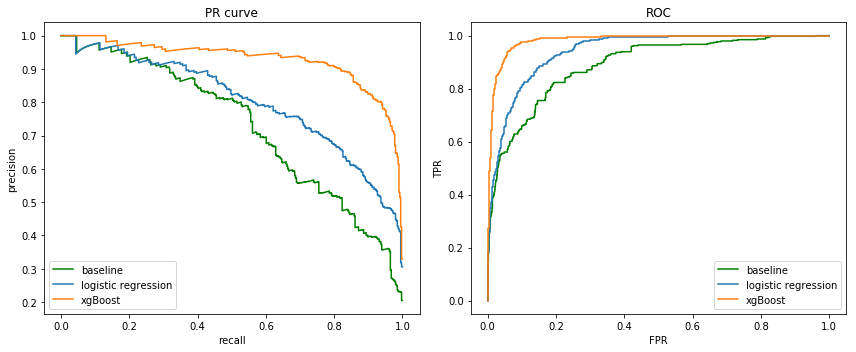

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, color ='g', label='baseline')
ax[0].plot(recall_2, precision_2, label='logistic regression')
ax[0].plot(recall_3, precision_3, label='xgBoost')
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc='best')

ax[1].plot(fpr, tpr, color='g', label='baseline')
ax[1].plot(fpr_2, tpr_2, label='logistic regression')
ax[1].plot(fpr_3, tpr_3, label='xgBoost')
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc='best')

fig.tight_layout()

Switching from a logistic regression to a xgBoost model results in a significant increase in performance: both the roc auc increases and the change is even more dramatic for the average precision. The difference is greater for high recall values: the xgBoost achieves 0.9 precision at 0.8 recall, while the logistic regression is only at 0.7 precision. Therefore, we can choose the xgBoost without hesitation as our model for this task.

## Feature Selection

### We try and identify features that are important for our best model. Questions now are: Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

Because we are using a pipeline with one_hot_encoded features, we need to manually redefine the features to get their correct names for the feature_importances plot of xgBoost.

In [103]:
#Computing the feature names for the plots
f_names = ['Total_Amount_of_Payment_USDollars']
for var in cat:
    for elem in [*working_df[var].unique()]:
        f_names.append(str(var)+'_'+str(elem))
    f_names.append(str(var)+'_N/A')
    
tuned_pipe.named_steps['classifier'].get_booster().feature_names = f_names

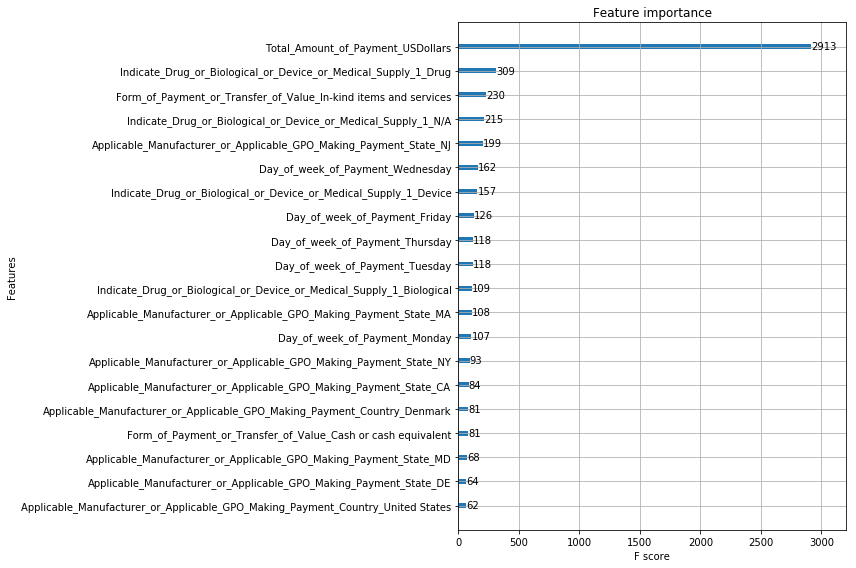

In [104]:
plt.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(1,1,figsize=(12,8))
xgb.plot_importance(tuned_pipe.named_steps['classifier'].get_booster(), ax=ax,max_num_features=20)
plt.tight_layout()

**Above is the plot of the top-20 feature importances for our xgBoost model. It must be noted that we limited the number to 20, but the actual number of features is 191.**

We can see that the continuous feature is the most important one when it comes to classifying. However one should be careful when interpreting such feature importance plots as the categorical variables have been split up in many features through one-hot-encoding and so their importance is diluted across all the binary features. Also, all insights gained from such a plot should be taken with a grain of salt as correlation between features can distort the algorithm's perception of how important each feature is.

From the graph, we can see that there are quite a few features that have been deemed quite less important. Therefore, we can wonder whether removing them will have any impact on the performance of the model.

To check that, we will include a step for feature selection within the pipeline: it uses a xgboost model with similar parameter to remove features which importance is lower than the mean importance accros all the features. 

**However, it must be noted that we are doing the feature selection on the one_hot_encoded features, which means that we are actually removing some of the values for one categorical feature, while keeping the rest for classification.**

In [105]:
from sklearn.feature_selection import SelectFromModel

encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat])
preprocess = make_column_transformer(('passthrough', cont), 
                                     (encoder, cat))

params = grid.best_params_

tuned_pipe = Pipeline(steps=[('preprocessor', preprocess),
                ('feature_selection', SelectFromModel(xgb.XGBClassifier(**params))),
                ("classifier",xgb.XGBClassifier(**params))])


tuned_pipe.fit(train, y_train)
#The estimator has been refitted to the entire dataset by the gridSearch based on the parameters for the
#best roc auc value
pipe_ap = average_precision_score(y_test, tuned_pipe.predict_proba(test)[:, 1])
pipe_ra = roc_auc_score(y_test, tuned_pipe.predict_proba(test)[:, 1])

print('The xgboost roc auc on the test set is {0:.3f}'.format(pipe_ra))
print('The xgboost average precision is {0:.3f}'.format(pipe_ap))

The xgboost roc auc on the test set is 0.974
The xgboost average precision is 0.895


Removing the least important features has little impact on the roc auc, but its impact is significant on the average precision. Let us now visualize once more the feature_importances plot for our model.

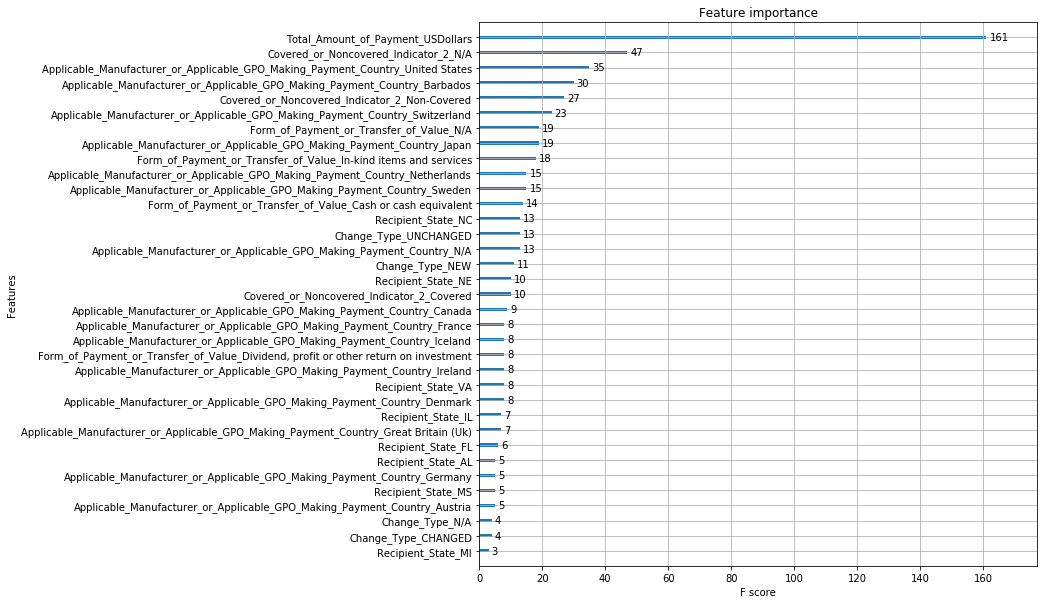

In [106]:
plt.rc('ytick', labelsize=10)

tuned_pipe.named_steps['classifier'].get_booster().feature_names = f_names
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(tuned_pipe.named_steps['classifier'].get_booster(), ax=ax)
plt.show()

Using the feature selection, we can see that we go from more than one hundred feature to less than fifty features. We can see that it has had a side-effect: the overall weights are way more balanced than before.


Overall, there is a slight decrease in roc auc, but a more significant decrease in average precision. Given that the xgBoost model trains very fast, it might not be useful to remove any features unless we want to have a more robust model that relies less on the continuous feature (if we know for instance that this feature might not be reliable for certain instances).

## Explainable Model

### We now try and create an “explainable” model that is nearly as good as our best model? We wish to obtain a model small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc.

For this part, we will use a decision tree because we can display the entire tree and get some interesting insights about how the model classifies instances.

We keep the same preprocessing as for the xgBoost model: no scaling for the continuous feature, but one_hot_encoding for each categorical feature. Furthermore, you set the max_depth of the tree at 4, since we want the model to be explainable i.e paths within the tree should be small enough to be easily understood by the user.

In [107]:
from sklearn.tree import DecisionTreeClassifier

encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat])
preprocess = make_column_transformer(('passthrough', cont), 
                                     (encoder, cat))
pipe_tree = Pipeline(steps=[('preprocessor', preprocess),
                ("classifier",DecisionTreeClassifier(max_depth=3))])

The **test scores** are:

In [108]:
tree_pipe = pipe_tree.fit(train, y_train)
tree_imp_ap = average_precision_score(y_test, pipe_tree.predict_proba(test)[:, 1])
tree_imp_ra = roc_auc_score(y_test, pipe_tree.predict_proba(test)[:, 1])

print('The decision tree roc auc is {0:.3f}'.format(tree_imp_ra))
print('The decision tree average precision is {0:.3f}'.format(tree_imp_ap))

The decision tree roc auc is 0.925
The decision tree average precision is 0.748


In [109]:
precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, tree_pipe.predict_proba(test)[:, 1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_test, tree_pipe.predict_proba(test)[:, 1])

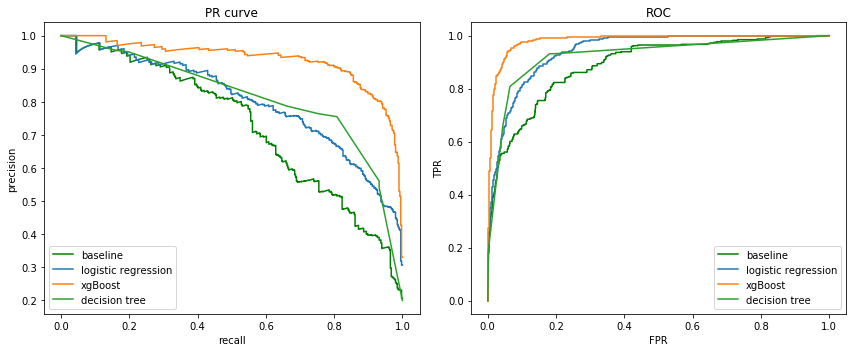

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, color ='g', label='baseline')
ax[0].plot(recall_2, precision_2, label='logistic regression')
ax[0].plot(recall_3, precision_3, label='xgBoost')
ax[0].plot(recall_4, precision_4, label='decision tree')
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc='best')

ax[1].plot(fpr, tpr, color='g', label='baseline')
ax[1].plot(fpr_2, tpr_2, label='logistic regression')
ax[1].plot(fpr_3, tpr_3, label='xgBoost')
ax[1].plot(fpr_4, tpr_4, label='decision tree')
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc='best')

fig.tight_layout()

We can see that the roc auc performance remain satisfying but there is a significant drop in average precision compared with the xgBoost. It is also very interesting to see that it still performs better than the logistic regression model which indicates that non-linear models seem to be more suited for this dataset.

In [113]:
import graphviz 
from sklearn import tree

f_names = ['Total_Amount_of_Payment_USDollars']
for var in cat:
    for elem in [*working_df[var].unique()]:
        f_names.append(str(var)+'_'+str(elem))
    f_names.append(str(var)+'_N/A')

dot_data = tree.export_graphviz(pipe_tree.named_steps['classifier'], 
                                out_file=None,feature_names=f_names) 
graph = graphviz.Source(dot_data) 
graph.render('tree',view=True)  

'tree.pdf'

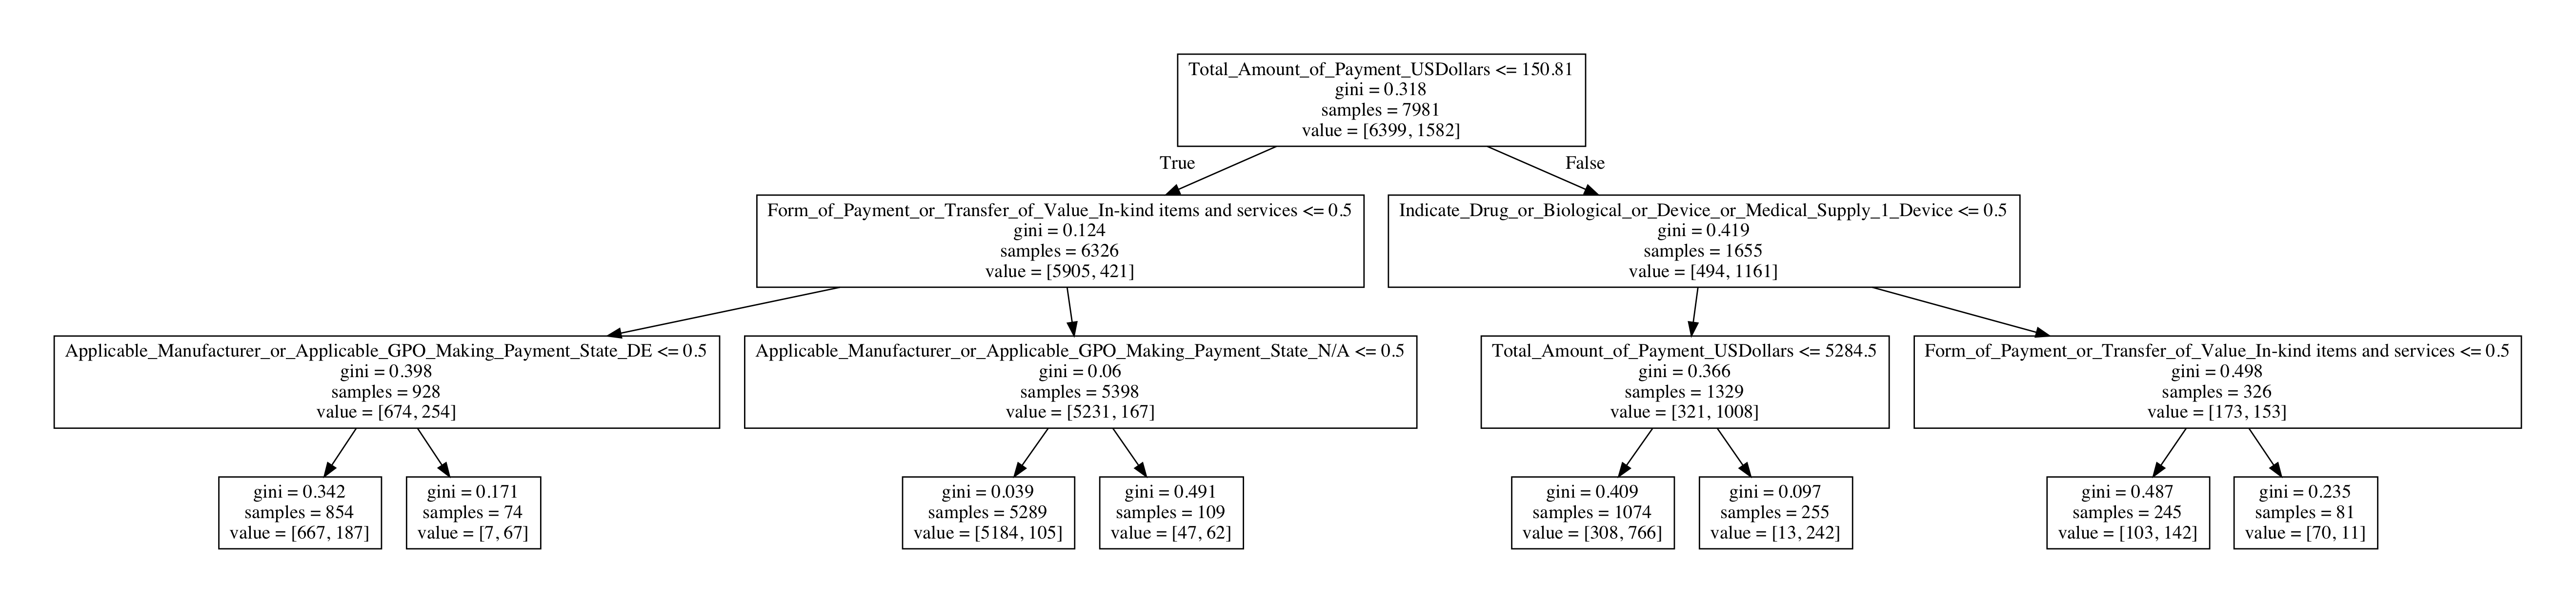

In [114]:
from IPython.display import Image
Image('tree.png')

From the graphviz tree, we can see how the model classifies instances. Unsurprisingly, the continuous feature is the most important one: it is the feature used for the first split, and it is subsequently reused for other splits. We can also find some of the features that were considered as important by the xgBoost model.